In [1]:
import os
import sys
sys.path.append('/lmh_data/work/SEE/train/')
sys.path.append('/lmh_data/work/SEE/analyse/')
import random

import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
from matplotlib.ticker import MultipleLocator

from util import array2mat, mat2array, mkdir

/root/miniconda3/envs/sclab/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
map_info = pd.read_csv('/lmh_data/data/sclab/sclab/map_result.csv', sep='\t', index_col=0)
rna = anndata.read_h5ad("/lmh_data/data/sclab/Human_M1_10x/scRNA.h5ad")
rna.obs.cell_type = rna.obs.cell_type.cat.rename_categories({'Oligo': 'ODC'})

cell_type, marker_gene_name = 'Astro', 'SLC1A2'
gene_name = 'DLC1'
eval_set = np.load('/lmh_data/data/sclab/sclab/AD/{}/train_dataset.npy'.format(gene_name), allow_pickle=True)
preds = np.load('/lmh_data/data/sclab/sclab/AD/{}/train_data_evaluate.npy'.format(gene_name), allow_pickle=True)

In [3]:
rna = rna[map_info.index]
rna = rna[rna.obs['cell_type'].isin([cell_type]),:]
rna.layers["counts"] = rna.X.copy()
rna

AnnData object with n_obs × n_vars = 525 × 50281
    obs: 'cell_type', 'domain'
    layers: 'counts'

In [4]:
_index = []
_rna = rna[:, eval_set[0]['scRNA_head']]
_rna_counts = _rna.layers["counts"].astype(np.int32)
for i in range(len(preds)):
    if eval_set[i]['identity'] == 'fake':
        continue
    if eval_set[i]['cell_type'] not in [cell_type]:
        continue
    for j in range(_rna.shape[0]):
        if (_rna_counts[j] == eval_set[i]['scRNA']).all():
            _index.append(_rna[j].obs.index[0])
            
rna = rna[_index]
rna

View of AnnData object with n_obs × n_vars = 466 × 50281
    obs: 'cell_type', 'domain'
    layers: 'counts'

/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be

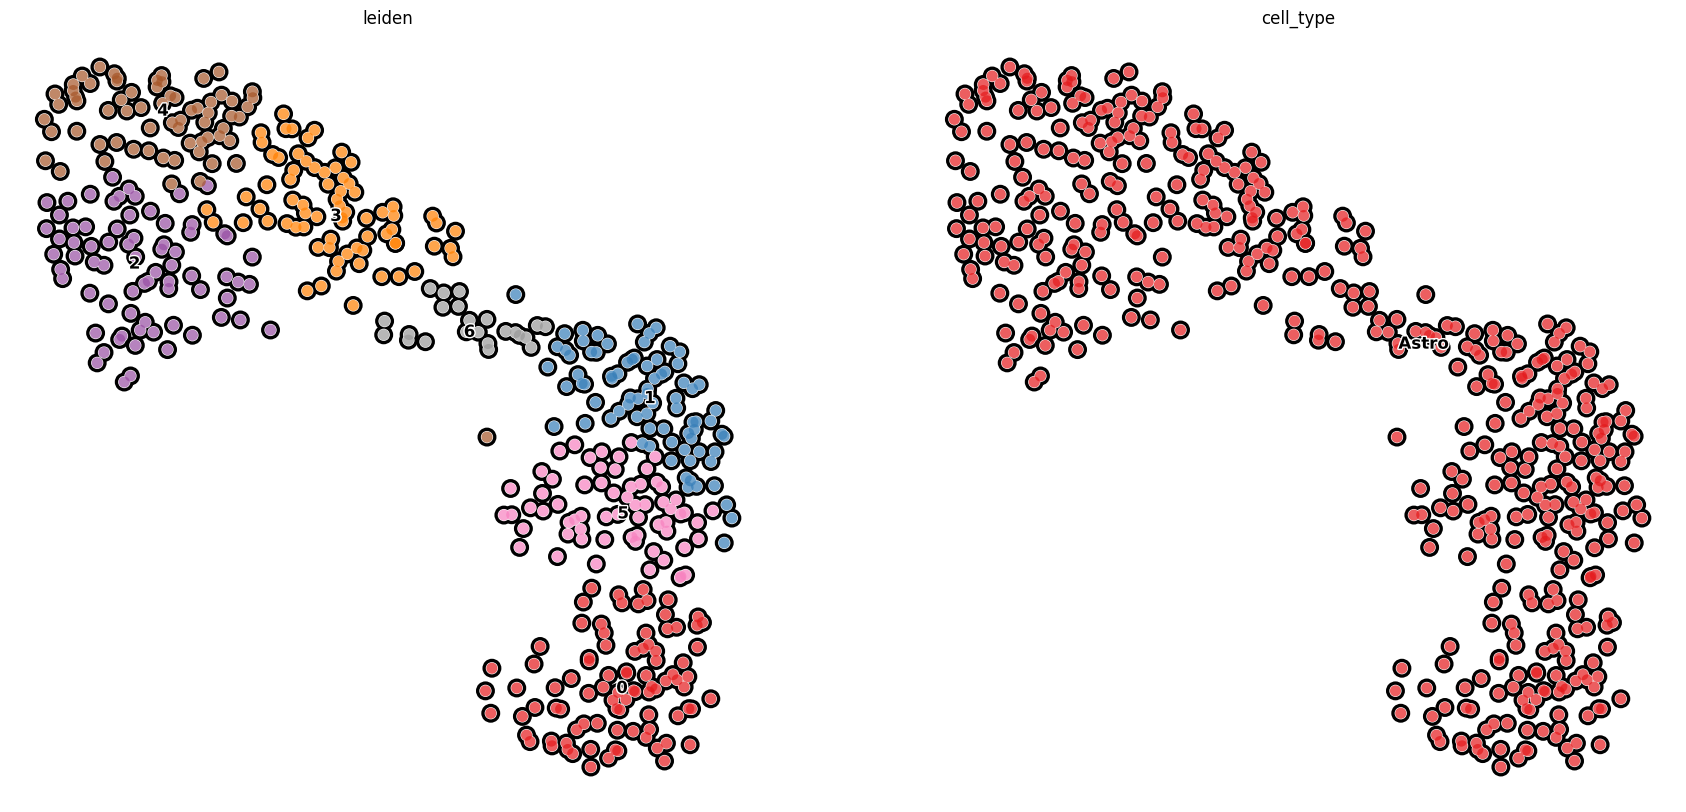

In [5]:
rna.X = rna.layers["counts"].copy()
sc.tl.pca(rna, n_comps=int(rna.shape[0]/5), svd_solver="auto")

sc.pp.neighbors(rna, metric="cosine")
sc.tl.umap(rna)
sc.tl.leiden(rna)

with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(rna, color=['leiden', 'cell_type'], add_outline=True, legend_loc='on data',
               legend_fontsize=12, legend_fontoutline=2, frameon=False, palette='Set1')

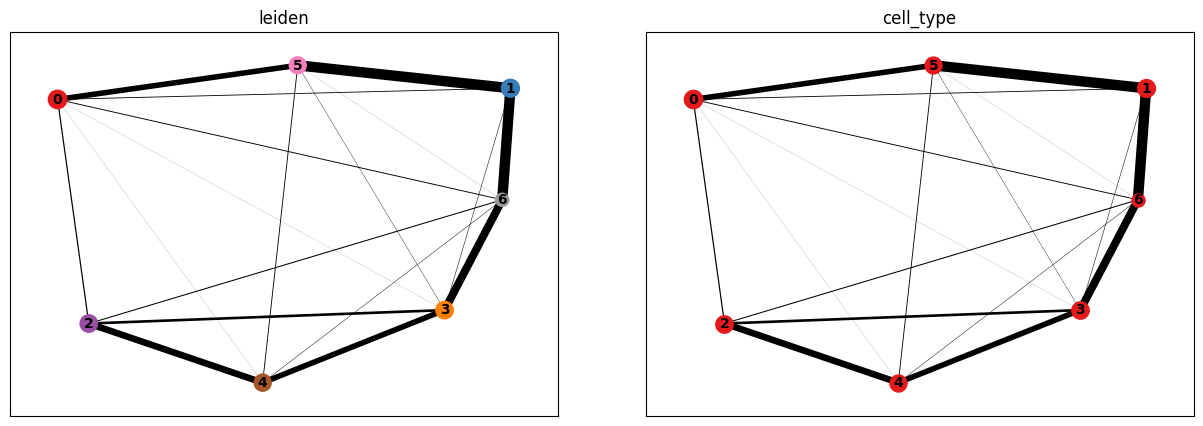

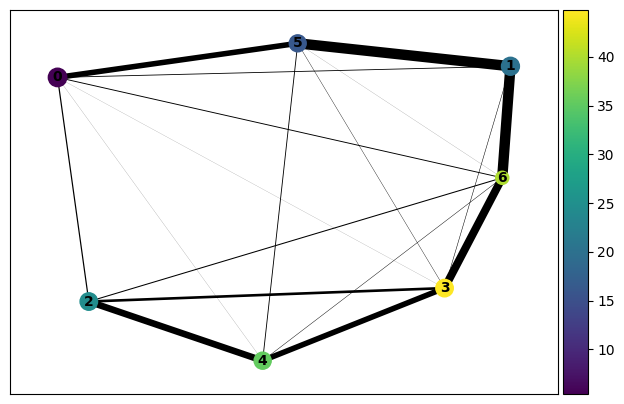

In [6]:
sc.tl.paga(rna, groups='leiden')
sc.pl.paga(rna, color=['leiden', 'cell_type'])
sc.pl.paga(rna, color=[marker_gene_name])

/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


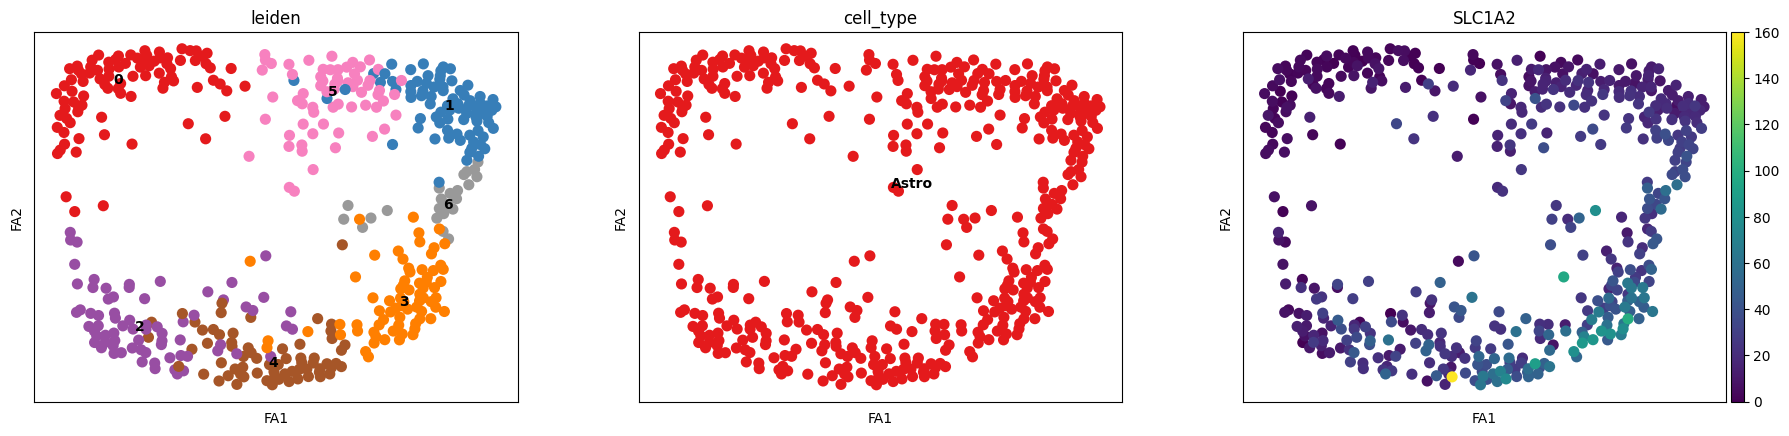

In [7]:
sc.tl.draw_graph(rna, init_pos='paga')
sc.pl.draw_graph(rna, color=['leiden', 'cell_type', marker_gene_name], legend_loc='on data')

/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


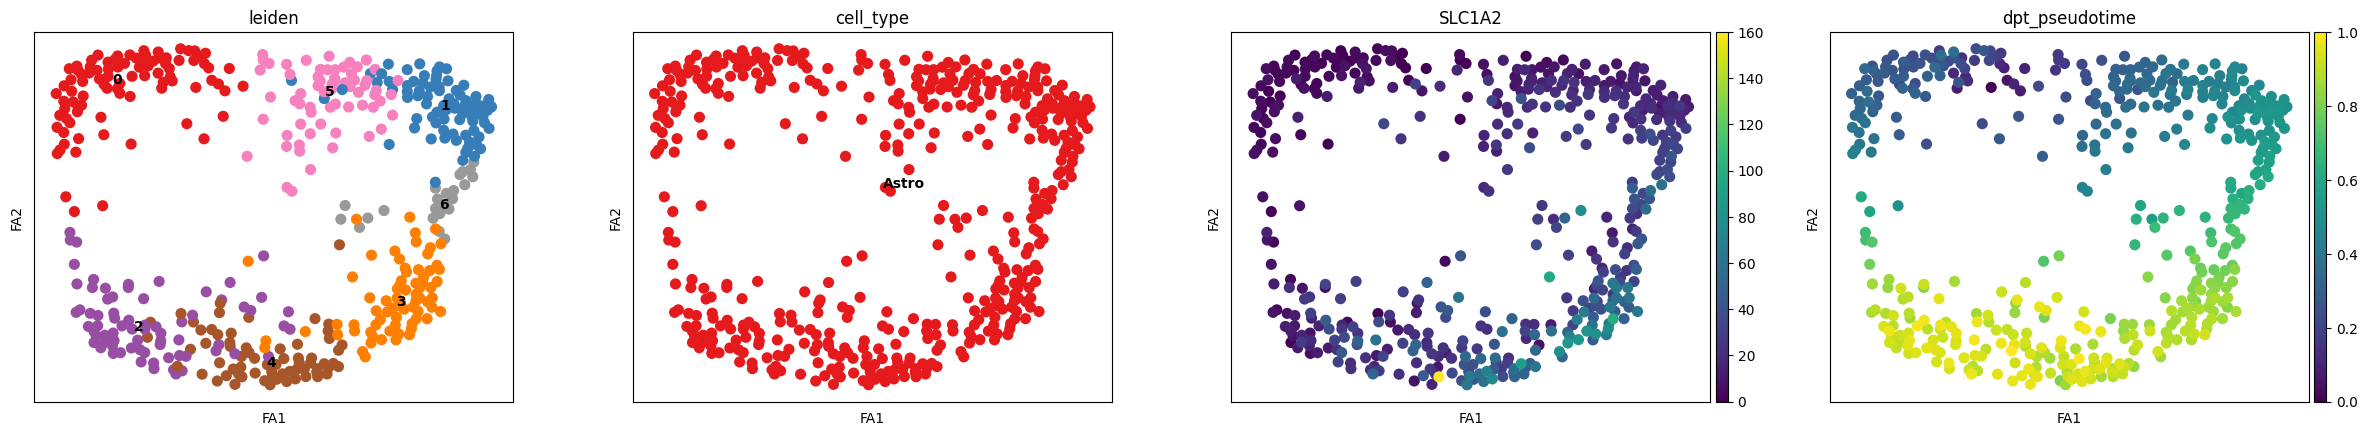

In [8]:
rna.uns['iroot'] = np.flatnonzero(rna.obs['leiden']=='0')[0]
sc.tl.dpt(rna)

sc.tl.draw_graph(rna, init_pos='paga')
sc.pl.draw_graph(rna, color=['leiden', 'cell_type', marker_gene_name, 'dpt_pseudotime'], legend_loc='on data')

/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(


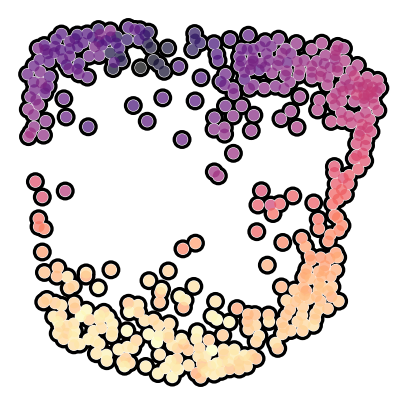

In [9]:
with rc_context({'figure.figsize': (5, 5)}):
    fig = sc.pl.draw_graph(rna, color=['dpt_pseudotime'], cmap='magma',
                     add_outline=True, legend_loc=None, colorbar_loc=None, title='', frameon=False, return_fig=True)
#     plt.savefig(
#         '/lmh_data/work/SEE/analyse/figure_file/pseudotime({}).pdf'.format(gene_name),
#         format='pdf', bbox_inches='tight')
    plt.show()

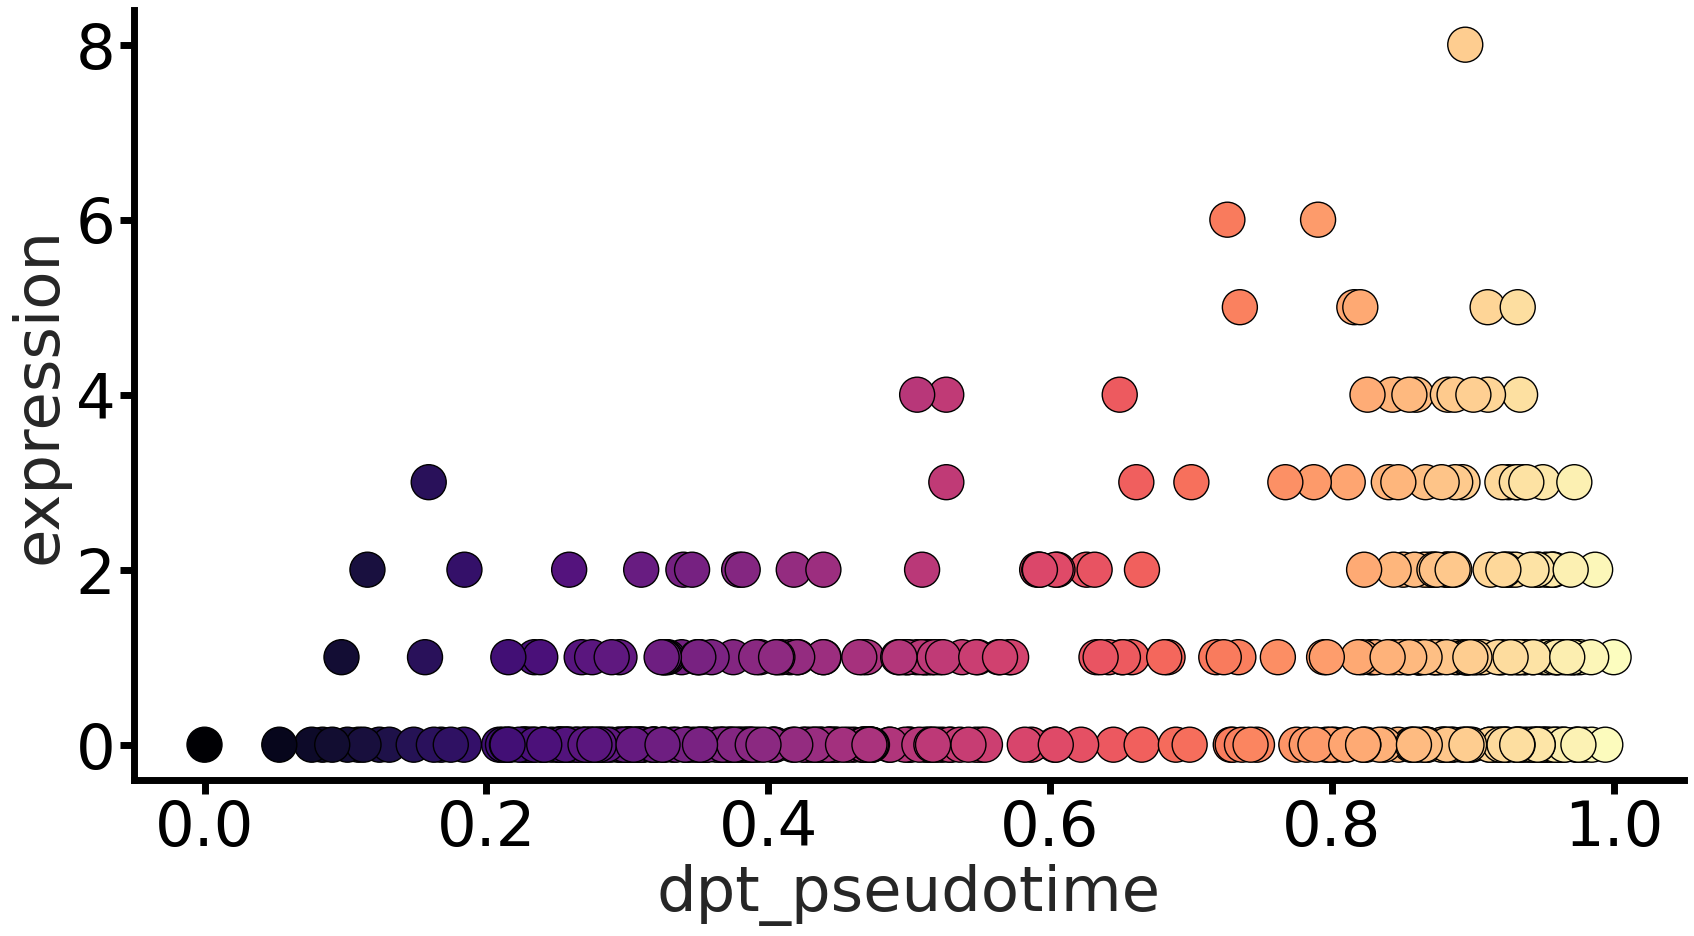

In [10]:
import seaborn as sns
from analyse_util import figure_size, set_plt, set_Border

set_plt(figsize=(20, 10))
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()

_x, _y = rna.obs['dpt_pseudotime'].values, rna[:, gene_name].layers["counts"].reshape(-1)
ax.scatter(_x, _y, edgecolors='black', s=(figure_size['large']*72./fig.dpi)**2, c=_x, cmap='magma')

set_Border(plt.gca())
plt.tick_params(colors='black', bottom=True, left=True, labelsize=figure_size['ultra'])
plt.grid(False)
plt.xlabel('dpt_pseudotime', fontsize=figure_size['ultra'])
plt.ylabel('expression', fontsize=figure_size['ultra'])
# plt.savefig(
#     '/lmh_data/work/SEE/analyse/figure_file/{} expression(ODC).pdf'.format(gene_name),
#     format='pdf', bbox_inches='tight')
plt.show()

In [11]:
scHiC = {}
_rna = rna[:, eval_set[0]['scRNA_head']]
_rna_counts = _rna.layers["counts"].astype(np.int32)
for i in range(len(preds)):
    if eval_set[i]['identity'] == 'fake':
        continue
    if eval_set[i]['cell_type'] not in [cell_type]:
        continue
    for j in range(_rna.shape[0]):
        if (_rna_counts[j] == eval_set[i]['scRNA']).all():
            scHiC[_rna[j].obs_names[0]] = preds[i]['predict']
            break
scHiC

{'AAGACTCAGGGAACAA-LKTX_190129_01_A01': array([0.35485664 , 0.009994023, 0.01355901 , ..., 0.2700531  ,
        0.014891341, 0.33554092 ], dtype=float32),
 'ACCCAAACAAGAGGCT-LKTX_190129_01_A01': array([0.43438134 , 0.023279767, 0.01362871 , ..., 0.30067396 ,
        0.019598931, 0.3577118  ], dtype=float32),
 'AGTACTGCAGATGCGA-LKTX_190129_01_A01': array([0.39931312 , 0.018671667, 0.012601834, ..., 0.28344572 ,
        0.011207432, 0.32985678 ], dtype=float32),
 'ATCGATGTCTGCGATA-LKTX_190129_01_A01': array([0.334566   , 0.017118782, 0.009545311, ..., 0.25090992 ,
        0.017975219, 0.30642352 ], dtype=float32),
 'ATTTCACTCCGTGTGG-LKTX_190129_01_A01': array([0.43097484 , 0.015211639, 0.0144624  , ..., 0.25503188 ,
        0.019904625, 0.3185416  ], dtype=float32),
 'CCATCACGTTCTCGCT-LKTX_190129_01_A01': array([0.3788959  , 0.0185776  , 0.015862927, ..., 0.23399244 ,
        0.016758546, 0.2721668  ], dtype=float32),
 'CCCTTAGAGGAGACCT-LKTX_190129_01_A01': array([0.32394534 , 0.00630435

In [12]:
_hics = []
for rna_name in rna.obs.sort_values(by='dpt_pseudotime').index:
    if rna_name not in scHiC.keys():
        continue
    _pseudotime = rna[rna_name].obs['dpt_pseudotime'].values[0]
    _hic = array2mat(scHiC[rna_name]).copy()
    if _hic.min() < 0:
        _hic += abs(_hic.min())
    _hics.append(_hic)

_diff_hic = np.zeros(_hics[0].shape, dtype=float)
_diff_frequency_hic = np.zeros(_hics[0].shape, dtype=float)
_tmp_hic = None
for i in range(1, len(_hics)):
    _diff_hic += abs(_hics[i] - _hics[i-1])
_diff_hic /= len(_hics) - 1
for i in range(1, len(_hics)):
    if _tmp_hic is not None:
        _hic = _hics[i] - _hics[i-1]
        _hic[_hic>_diff_hic.mean()] = 1
        _hic[_hic<-_diff_hic.mean()] = -1
        _hic[(_hic>=-_diff_hic.mean())&(_hic<=_diff_hic.mean())] = 0
        
        _diff = _hic != _tmp_hic
        _diff_frequency_hic[_diff] += 1
        
    _tmp_hic = _hics[i] - _hics[i-1]
    _tmp_hic[_tmp_hic>_diff_hic.mean()] = 1
    _tmp_hic[_tmp_hic<-_diff_hic.mean()] = -1
    _tmp_hic[(_tmp_hic>=-_diff_hic.mean())&(_tmp_hic<=_diff_hic.mean())] = 0

_diff_frequency_hic /= len(_hics) - 1

In [13]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def colorbar_triangle(axm,im,ymax):
    height="2%"
    width="10%"
    if ymax!=None:
        height="6%"
    axins1 = inset_axes(axm, width=width, height=height, loc=4, bbox_to_anchor=(-0.1, 0.7, 1.2, 2.9), bbox_transform=axm.transAxes,)
    cbar=plt.colorbar(im, cax=axins1, orientation='horizontal')
    cbar.ax.xaxis.tick_top()
    cbar.ax.spines['top'].set_color('none')
    cbar.ax.spines['right'].set_color('none')
    cbar.ax.spines['bottom'].set_color('none')
    cbar.ax.spines['left'].set_color('none')


def heatmap_triangle(
    axes, mat, matBalance=False,
    width=6, height=3, norm=None, cmap=mpl.cm.YlGnBu, showXticks=True, title=None, ymax=None, logData=False
):
    if logData == True:
        mat = np.log2(mat)

    N = mat.shape[1]

    # Transformation matrix for rotating the heatmap.
    A = np.array([(y, x) for x in range(N, -1, -1) for y in range(N + 1)])
    t = np.array([[1,0.5], [-1,0.5]])
    A = np.dot(A, t)

    C = np.triu(mat)

    # This MUST be before the call to pl.pcolormesh() to align properly.
    #axes.set_xticks([])
    axes.set_yticks([])

    # Plot the correlation heatmap triangle.
    X = A[:, 1].reshape(N + 1, N + 1)
    Y = A[:, 0].reshape(N + 1, N + 1)

    caxes = axes.pcolormesh(X, Y, np.flipud(C), axes=axes, norm=norm, cmap=cmap, edgecolor='none', snap=True, linewidth=.001)

    # Remove the ticks and reset the x limit.

    axes.set_ylim(bottom=0)
    axes.set_xlim(left=0)
    if ymax != None:
        axes.set_ylim(top=ymax)
    axes.set_title(title)
    
    #set_heatmap_ticks(axes)
    
    axes.axis("off")
    colorbar_triangle(axes, caxes, ymax)
    
def plot_gene(ax, gene_bed, chrom, start, end, line=1, gene_col=[], fontszie=5):
    gene_bed = gene_bed[gene_bed['chrom']==chrom]
    gene_bed_plot = gene_bed[((gene_bed['start'] >= start) & (gene_bed['start'] <= end)) | ((gene_bed['end'] >= start) & (gene_bed['end'] <= end))]
    gene_bed_plot = gene_bed_plot.sort_values(by='end')
    line = max(line, gene_bed_plot.shape[0])
    
    plot_gene_num = gene_bed_plot.shape[0]
    if line == 1:
        for i,row in gene_bed_plot.iterrows():
            ax.plot((row['start'], row['end']), (0.5, 0.5), color='b')
            starts = row["blockStarts"]
            widths = row["blockSizes"]
            
            ax.bar(x=starts, height=1, width=widths, bottom=0, \
                   edgecolor='black', linewidth=0, align='edge', color='b', ecolor=None)
    else:
        ii = 0
        for i,row in gene_bed_plot.iterrows():
            col = "#3366CC"
            text_col = '#3366CC'
            
            if row["strand"] == "-":
                col = "#EECFA1"
                text_col = '#EECFA1'
            
            #text_col = col
            plot_y = ii%line
            
            if i in gene_col:
                col = "red"
                text_col = "red"
            
            ax.plot((row['start'], row['end']), (plot_y + 0.5, plot_y+0.5), color=col)
            starts = row["blockStarts"]
            widths = row["blockSizes"]
            
            ax.bar(x=starts, height=0.8, width=widths, bottom=plot_y+0.1, \
                   edgecolor=col, linewidth=0.3, align='edge', color=col)
            
            if row['start'] < start:
                    row['start'] = start
            if row['end'] > end:
                    row['end'] = end
            
#             if (gene_bed_plot.iloc[-1]['name'] == i) or (gene_bed_plot.iloc[-2]['name'] == i) or (gene_bed_plot.iloc[-3]['name'] == i):
#                 ax.text(row['start'], plot_y + 0.5, i + "  ", ha='right', va='center',color=text_col, fontsize=fontszie)
#             else:
#                 ax.text(row['end'], plot_y + 0.5, "  " + i, ha='left', va='center',color=text_col, fontsize=fontszie)
            ax.text(row['start'], plot_y + 0.5, i + "  ", ha='right', va='center',color=text_col, fontsize=fontszie)

            ii+=1
            
    ax.set_xlim(start,end)
    ax.set_ylim(top=0, bottom=line)
    if plot_gene_num < line:
        ax.spines['bottom'].set_position(('data', plot_gene_num))
    
    for i in ['left','top','right']:
        ax.spines[i].set_color('none')
        ax.spines[i].set_linewidth(0)
    ax.spines["bottom"].set_color('black')
    ax.spines["bottom"].set_linewidth(0.5)
    ax.tick_params(bottom =True,top=False,left=False,right=False)
    #ax.set_xticklabels("")
    ax.set_yticklabels("")
    
def plot_bwTrack(ax, bw, ylabel, chrom, start, end, resolution=20000 , yminx=5, ymaxx=95,rotation=0, fl='%0.2f',color
='#464451'):
    ax.tick_params(bottom=False,top=False,left=True,right=False)
    ax.spines['left'].set_color('k')
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_color('k')
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['top'].set_color('none')
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_color('none')
    ax.spines['right'].set_linewidth(0)

    x = int((end-start)/resolution)

    plot_list = bw.stats(chrom, start, end, type="mean", nBins=x)
    plot_list = [0 if v is None else v  for v in plot_list]
    
    width = 1
    ax.bar(x=range(0,x), height=plot_list, width=1, bottom=[0]*(x),color=color,align="edge",edgecolor=color)    
    ax.set_xlim(0,x)

    #ax.set_xticks([])
    #ax.set_xticklabels([])

    ymin = np.percentile(plot_list,yminx)
    ymax = np.percentile(plot_list,ymaxx)

    ax.set_yticks([ymin, ymax])
    ax.set_yticklabels([fl % ymin, fl % ymax], fontsize=7)
    
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel(ylabel, fontsize=8, rotation=rotation, horizontalalignment='right',verticalalignment='center')
    
    ax.set_xticks([])
    ax.set_xticklabels('')
    
def pre_track(predict_mat, title=None):
    fig = plt.figure(figsize=(20, 9), facecolor='white')
    plt.subplots_adjust(left=0.2, bottom=0.1, right=0.8, top=0.8, hspace=0.3, wspace=0.15)

    gs = fig.add_gridspec(9, 1)
    ax0 = fig.add_subplot(gs[0:8, 0], facecolor='white')

    _test = predict_mat.copy()
    row, col = np.diag_indices_from(_test)
    _diag = _test[row,col].copy()
    
    _test[row,col] = 0
    _min = _test[_test!=0].min()
    _test[_test!=0] -= _min
    _test /= _test.max()
    heatmap_triangle(ax0, _test, width=6, height=2.7, logData=False, cmap=mpl.cm.Greys)

    if title:
        plt.savefig(os.path.join('/lmh_data/work/SEE/analyse/figure_file/', title), format='pdf', bbox_inches='tight')
    plt.show()

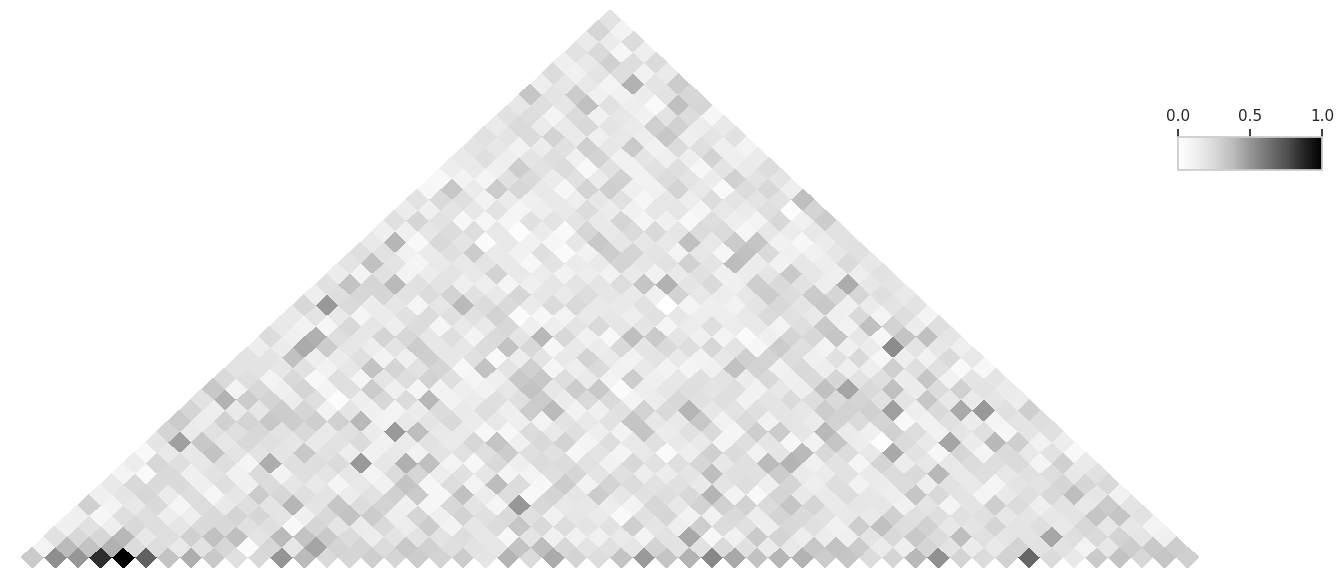

In [14]:
pre_track(_diff_hic)

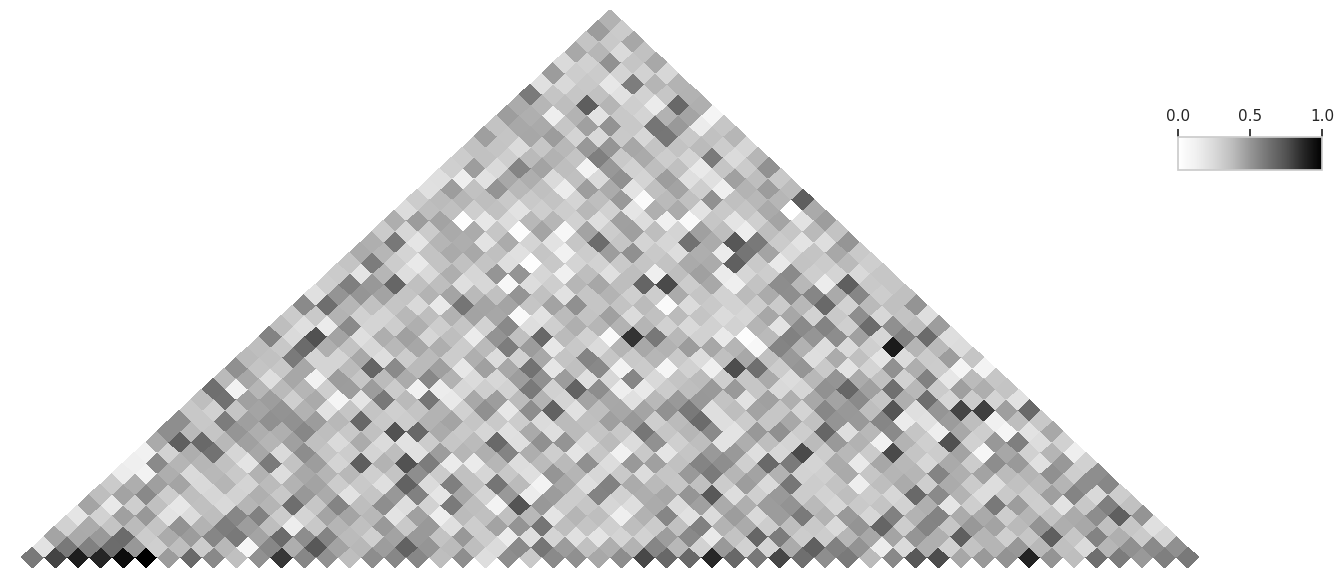

In [15]:
pre_track(_diff_frequency_hic)

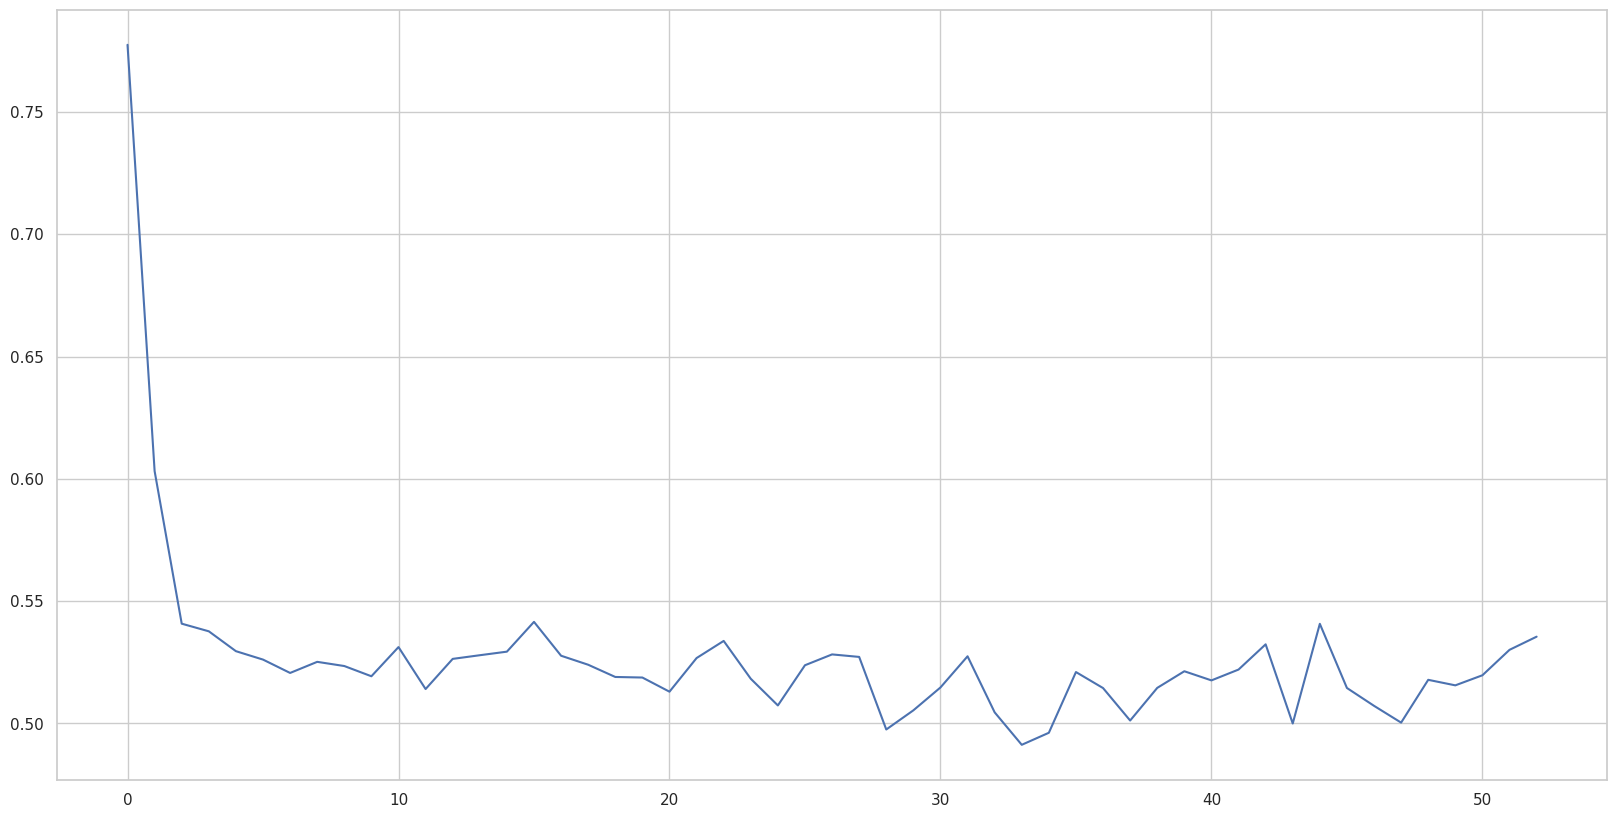

In [16]:
test = []
for i in range(_diff_frequency_hic.shape[0]):
    test.append(np.diagonal(_diff_frequency_hic, offset=i).mean())

plt.plot(test)
plt.show()

In [17]:
AD_evals = np.load('/lmh_data/data/sclab/sclab/AD/eval_dataset.npy', allow_pickle=True)
AD_preds = np.load('/lmh_data/data/sclab/sclab/AD/{}/AD_evaluate.npy'.format(gene_name), allow_pickle=True)

chrom, start, end = 'chr8', 12940000, 13470000

In [18]:
v19_anno = pd.read_csv('/lmh_data/data/sclab/public/gencode.v19.annotation.gtf',
                       header=None, sep='\t', skiprows=[i for i in range(5)], usecols=[0, 2, 3, 4, 6, 8], names=[
                           'chrom', 'type', 'start', 'end', 'strand', 'info'
                       ])
v19_anno['gene_name'] = v19_anno['info'].str.extract(r'(gene_name ")(\S*)(")')[1]
v19_anno['transcript_name'] = v19_anno['info'].str.extract(r'(transcript_name ")(\S*)(")')[1]
v19_anno

,chrom,type,start,end,strand,info,gene_name,transcript_name
0,chr1,gene,11869,14412,+,"gene_id ""ENSG00000223972.4""; transcript_id ""EN...",DDX11L1,DDX11L1
1,chr1,transcript,11869,14409,+,"gene_id ""ENSG00000223972.4""; transcript_id ""EN...",DDX11L1,DDX11L1-002
2,chr1,exon,11869,12227,+,"gene_id ""ENSG00000223972.4""; transcript_id ""EN...",DDX11L1,DDX11L1-002
3,chr1,exon,12613,12721,+,"gene_id ""ENSG00000223972.4""; transcript_id ""EN...",DDX11L1,DDX11L1-002
4,chr1,exon,13221,14409,+,"gene_id ""ENSG00000223972.4""; transcript_id ""EN...",DDX11L1,DDX11L1-002
...,...,...,...,...,...,...,...,...
2619439,chrM,transcript,15888,15953,+,"gene_id ""ENSG00000210195.2""; transcript_id ""EN...",MT-TT,MT-TT-201
2619440,chrM,exon,15888,15953,+,"gene_id ""ENSG00000210195.2""; transcript_id ""EN...",MT-TT,MT-TT-201
2619441,chrM,gene,15956,16023,-,"gene_id ""ENSG00000210196.2""; transcript_id ""EN...",MT-TP,MT-TP
2619442,chrM,transcript,15956,16023,-,"gene_id ""ENSG00000210196.2""; transcript_id ""EN...",MT-TP,MT-TP-201


In [19]:
transcript_info = v19_anno[v19_anno['type']=='transcript'].copy()
transcript_info = transcript_info.set_index('transcript_name')
transcript_info = transcript_info.drop(labels='info', axis=1)
transcript_info = transcript_info.drop(labels='type', axis=1)

exons = v19_anno[(v19_anno['type']=='exon')&(v19_anno['transcript_name'].isin(transcript_info.index))].copy()
exons['blockSizes'] = exons['end'] - exons['start']
exons['blockStarts'] = exons['start']
exons_group = exons.groupby("transcript_name")
transcript_info['blockCount'] = exons_group['blockStarts'].count()
transcript_info['blockSizes'] = exons_group['blockSizes'].apply(list)
transcript_info['blockStarts'] = exons_group['blockStarts'].apply(list)
transcript_info

,chrom,start,end,strand,gene_name,blockCount,blockSizes,blockStarts
transcript_name,,,,,,,,
DDX11L1-002,chr1,11869,14409,+,DDX11L1,3,"[358, 108, 1188]","[11869, 12613, 13221]"
DDX11L1-201,chr1,11872,14412,+,DDX11L1,3,"[355, 108, 1187]","[11872, 12613, 13225]"
DDX11L1-202,chr1,11874,14409,+,DDX11L1,4,"[353, 126, 252, 748]","[11874, 12595, 13403, 13661]"
DDX11L1-001,chr1,12010,13670,+,DDX11L1,6,"[47, 48, 84, 77, 153, 217]","[12010, 12179, 12613, 12975, 13221, 13453]"
WASH7P-202,chr1,14363,29370,-,WASH7P,12,"[49, 153, 111, 146, 140, 131, 201, 158, 43, 10...","[29321, 24738, 18268, 17915, 17602, 17233, 168..."
...,...,...,...,...,...,...,...,...
MT-ND6-201,chrM,14149,14673,-,MT-ND6,1,[524],[14149]
MT-TE-201,chrM,14674,14742,-,MT-TE,1,[68],[14674]
MT-CYB-201,chrM,14747,15887,+,MT-CYB,1,[1140],[14747]


In [20]:
def show_by_cell_type(evals, preds, cell_type=None, Diagnosis=None, ignore_diag=True):
    _pred, _tar = None, None
    num = 0
    for i in range(len(preds)):
        pred = preds[i]
        if cell_type and evals[i]['cell_type'] != cell_type:
            continue
        if Diagnosis and evals[i]['Diagnosis'] != Diagnosis:
            continue
        num += 1
        _predict, _target = pred['predict'].copy(), pred['target'].copy()
        _predict += abs(_predict.min())
        if ignore_diag:
            _predict = array2mat(_predict)
            np.fill_diagonal(_predict, 0)
            _predict = mat2array(_predict)
        _predict /= _predict.sum()
        if _pred is None:
            _pred, _tar = _predict, _target
        else:
            _pred += _predict
            _tar += _target
    return _pred/num, _tar/num

In [21]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def colorbar_triangle(axm,im,ymax):
    height="2%"
    width="10%"
    if ymax!=None:
        height="6%"
    axins1 = inset_axes(axm, width=width, height=height, loc=4, bbox_to_anchor=(-0.1, 0.7, 1.2, 2.9), bbox_transform=axm.transAxes,)
    cbar=plt.colorbar(im, cax=axins1, orientation='horizontal')
    cbar.ax.xaxis.tick_top()
    cbar.ax.spines['top'].set_color('none')
    cbar.ax.spines['right'].set_color('none')
    cbar.ax.spines['bottom'].set_color('none')
    cbar.ax.spines['left'].set_color('none')


def heatmap_triangle(
    axes, mat, matBalance=False,
    width=6, height=3, norm=None, cmap=mpl.cm.YlGnBu, showXticks=True, title=None, ymax=None, logData=False
):
    if logData == True:
        mat = np.log2(mat)

    N = mat.shape[1]

    # Transformation matrix for rotating the heatmap.
    A = np.array([(y, x) for x in range(N, -1, -1) for y in range(N + 1)])
    t = np.array([[1,0.5], [-1,0.5]])
    A = np.dot(A, t)

    C = np.triu(mat)

    # This MUST be before the call to pl.pcolormesh() to align properly.
    #axes.set_xticks([])
    axes.set_yticks([])

    # Plot the correlation heatmap triangle.
    X = A[:, 1].reshape(N + 1, N + 1)
    Y = A[:, 0].reshape(N + 1, N + 1)

    caxes = axes.pcolormesh(X, Y, np.flipud(C), axes=axes, norm=norm, cmap=cmap, edgecolor='none', snap=True, linewidth=.001)

    # Remove the ticks and reset the x limit.

    axes.set_ylim(bottom=0)
    axes.set_xlim(left=0)
    if ymax != None:
        axes.set_ylim(top=ymax)
    axes.set_title(title)
    
    #set_heatmap_ticks(axes)
    
    axes.axis("off")
    colorbar_triangle(axes, caxes, ymax)
    
def plot_gene(ax, gene_bed, chrom, start, end, line=1, gene_col=[], fontszie=5):
    gene_bed = gene_bed[gene_bed['chrom']==chrom]
    gene_bed_plot = gene_bed[((gene_bed['start'] >= start) & (gene_bed['start'] <= end)) | ((gene_bed['end'] >= start) & (gene_bed['end'] <= end))]
    gene_bed_plot = gene_bed_plot.sort_values(by='end')
    line = max(line, gene_bed_plot.shape[0])
    
    plot_gene_num = gene_bed_plot.shape[0]
    if line == 1:
        for i,row in gene_bed_plot.iterrows():
            ax.plot((row['start'], row['end']), (0.5, 0.5), color='b')
            starts = row["blockStarts"]
            widths = row["blockSizes"]
            
            ax.bar(x=starts, height=1, width=widths, bottom=0, \
                   edgecolor='black', linewidth=0, align='edge', color='b', ecolor=None)
    else:
        ii = 0
        for i,row in gene_bed_plot.iterrows():
            col = "#3366CC"
            text_col = '#3366CC'
            
            if row["strand"] == "-":
                col = "#EECFA1"
                text_col = '#EECFA1'
            
            #text_col = col
            plot_y = ii%line
            
            if i in gene_col:
                col = "red"
                text_col = "red"
            
            ax.plot((row['start'], row['end']), (plot_y + 0.5, plot_y+0.5), color=col)
            starts = row["blockStarts"]
            widths = row["blockSizes"]
            
            ax.bar(x=starts, height=0.8, width=widths, bottom=plot_y+0.1, \
                   edgecolor=col, linewidth=0.3, align='edge', color=col)
            
            if row['start'] < start:
                    row['start'] = start
            if row['end'] > end:
                    row['end'] = end
            
#             if (gene_bed_plot.iloc[-1]['name'] == i) or (gene_bed_plot.iloc[-2]['name'] == i) or (gene_bed_plot.iloc[-3]['name'] == i):
#                 ax.text(row['start'], plot_y + 0.5, i + "  ", ha='right', va='center',color=text_col, fontsize=fontszie)
#             else:
#                 ax.text(row['end'], plot_y + 0.5, "  " + i, ha='left', va='center',color=text_col, fontsize=fontszie)
            ax.text(row['start'], plot_y + 0.5, i + "  ", ha='right', va='center',color=text_col, fontsize=fontszie)

            ii+=1
            
    ax.set_xlim(start,end)
    ax.set_ylim(top=0, bottom=line)
    if plot_gene_num < line:
        ax.spines['bottom'].set_position(('data', plot_gene_num))
    
    for i in ['left','top','right']:
        ax.spines[i].set_color('none')
        ax.spines[i].set_linewidth(0)
    ax.spines["bottom"].set_color('black')
    ax.spines["bottom"].set_linewidth(0.5)
    ax.tick_params(bottom =True,top=False,left=False,right=False)
    #ax.set_xticklabels("")
    ax.set_yticklabels("")
    
def plot_bwTrack(ax, bw, ylabel, chrom, start, end, resolution=20000 , yminx=5, ymaxx=95,rotation=0, fl='%0.2f',color
='#464451'):
    ax.tick_params(bottom=False,top=False,left=True,right=False)
    ax.spines['left'].set_color('k')
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_color('k')
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['top'].set_color('none')
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_color('none')
    ax.spines['right'].set_linewidth(0)

    x = int((end-start)/resolution)

    plot_list = bw.stats(chrom, start, end, type="mean", nBins=x)
    plot_list = [0 if v is None else v  for v in plot_list]
    
    width = 1
    ax.bar(x=range(0,x), height=plot_list, width=1, bottom=[0]*(x),color=color,align="edge",edgecolor=color)    
    ax.set_xlim(0,x)

    #ax.set_xticks([])
    #ax.set_xticklabels([])

    ymin = np.percentile(plot_list,yminx)
    ymax = np.percentile(plot_list,ymaxx)

    ax.set_yticks([ymin, ymax])
    ax.set_yticklabels([fl % ymin, fl % ymax], fontsize=7)
    
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel(ylabel, fontsize=8, rotation=rotation, horizontalalignment='right',verticalalignment='center')
    
    ax.set_xticks([])
    ax.set_xticklabels('')

In [22]:
import pyBigWig

ATAC_ASC_AD = pyBigWig.open('/lmh_data/data/sclab/syn22092838/ASC_AD_hg19.bw')
ATAC_ASC_Control = pyBigWig.open('/lmh_data/data/sclab/syn22092838/ASC_Control_hg19.bw')

In [23]:
import matplotlib.colors as colors

def pre_track(predict_array, gene_name, cell_type, title=None):
    fig = plt.figure(figsize=(20, 9), facecolor='white')
    plt.subplots_adjust(left=0.2, bottom=0.1, right=0.8, top=0.8, hspace=0.3, wspace=0.15)

    gs = fig.add_gridspec(17, 1)
    ax0 = fig.add_subplot(gs[0:8, 0], facecolor='white')
    ax1 = fig.add_subplot(gs[8, 0], facecolor='white')
    ax2 = fig.add_subplot(gs[9, 0], facecolor='white')
    ax3 = fig.add_subplot(gs[10, 0], facecolor='white')
    ax4 = fig.add_subplot(gs[11, 0], facecolor='white')
    ax5 = fig.add_subplot(gs[12:17, 0], facecolor='white')

    _test = array2mat(predict_array)
    heatmap_triangle(ax0, _test, width=6, height=2.7, norm=colors.CenteredNorm(), cmap='RdBu_r', logData=False)

    plot_bwTrack(ax1, ATAC_ASC_AD, "ATAC(AD)", chrom, start, end, resolution=100,
                 yminx=0, ymaxx=100,rotation=0, fl='%0.2f',color='#62D6E3')
    plot_bwTrack(ax2, ATAC_ASC_Control, "ATAC(Control)", chrom, start, end, resolution=100,
                 yminx=0, ymaxx=100,rotation=0, fl='%0.2f',color='#62D6E3')
    plot_gene(ax5, transcript_info, chrom, start, end, line=10, gene_col=[], fontszie=8)
    
    if title:
        plt.savefig(os.path.join('/lmh_data/work/SEE/analyse/figure_file/', title), format='pdf', bbox_inches='tight')
    plt.show()

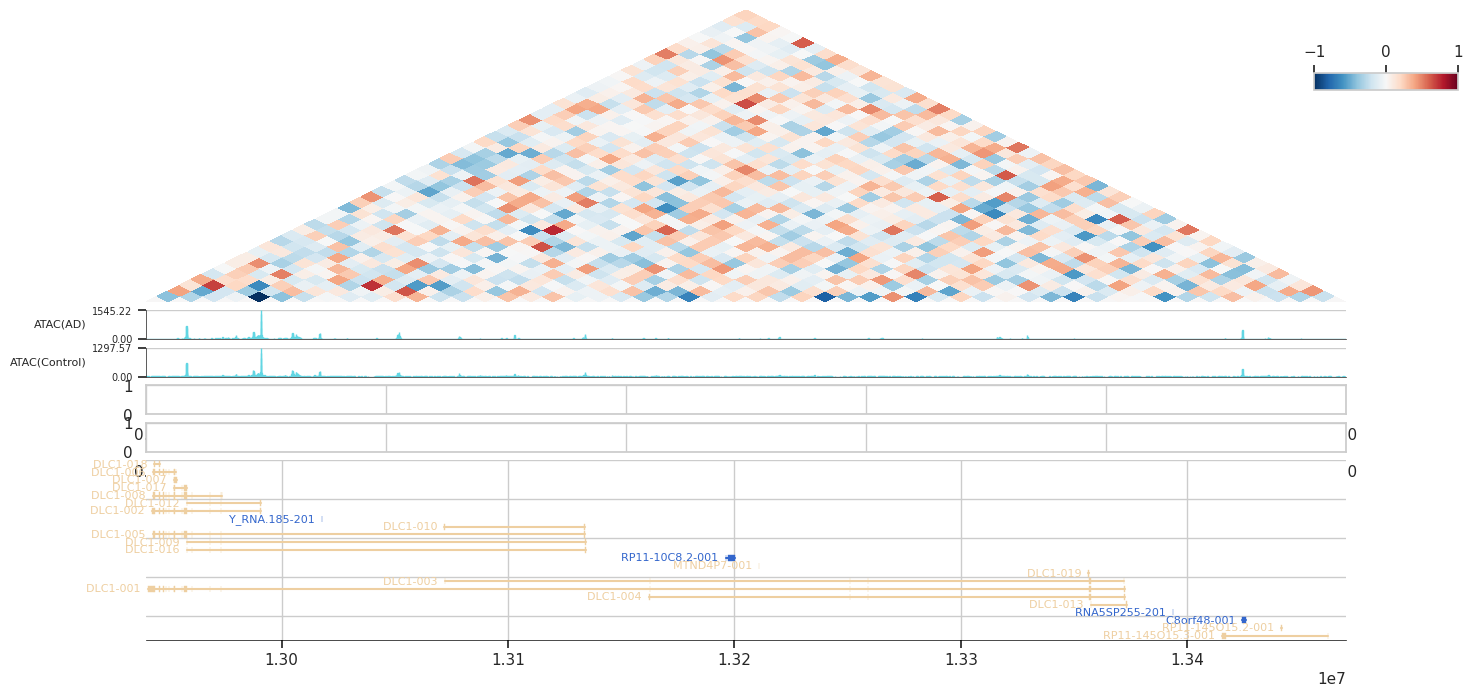

In [24]:
control_hic = show_by_cell_type(AD_evals, AD_preds, cell_type, 'control')[0]
AD_hic = show_by_cell_type(AD_evals, AD_preds, cell_type, 'AD')[0]

_tmp = AD_hic - control_hic
_tmp /= max(_tmp.max(), abs(_tmp.min()))
pre_track(_tmp, gene_name, cell_type)

In [25]:
import pyBigWig

ATAC_bw = pyBigWig.open('/lmh_data/data/sclab/source/Astro/impute_BSS00089_ATAC-seq.bigWig')
H3K27ac_bw = pyBigWig.open('/lmh_data/data/sclab/source/Astro/impute_BSS00089_H3K27ac.bigWig')
POLR2A_bw = pyBigWig.open('/lmh_data/data/sclab/source/Astro/impute_BSS00089_POLR2A.bigWig')

resolution = 10000


ATAC_plot_list = ATAC_bw.stats(chrom, start, end, type="mean", nBins=int((end-start)/resolution))
H3K27ac_plot_list = H3K27ac_bw.stats(chrom, start, end, type="mean", nBins=int((end-start)/resolution))
POLR2A_plot_list = POLR2A_bw.stats(chrom, start, end, type="mean", nBins=int((end-start)/resolution))

def cal_scores(plot_list):
    values = [0 if v is None or np.isnan(v) else v for v in plot_list]

    scores = np.zeros((len(values), len(values)))
    for i in range(len(values)):
        for j in range(len(values)):
            scores[i, j] = (values[i] + values[j]) / 2
    scores = mat2array(scores)
    scores -= scores.min()
    scores /= scores.max()
    return scores

In [26]:
sys.path.append('/lmh_data/work/SEE/analyse/')
from analyse_util import figure_size, set_plt, set_Border


def dynamic_vs_diseasediff(matrix, scores, max_num, output_path=None):
    diffhic = matrix.copy()
    row, col = np.diag_indices_from(diffhic)
    _diag = diffhic[row,col].copy()
    diffhic[row,col] = 0
#     _min = diffhic[diffhic!=0].min()
#     diffhic[diffhic!=0] -= _min
#     diffhic /= diffhic.max()
    diffhic /= max_num

    diffhic = mat2array(diffhic)

    _x, _y, _z = [], [], []
    for i in range(_tmp.shape[0]):
        if diffhic[i] == 0:
            continue
        _x.append(abs(_tmp[i]))
        _y.append(diffhic[i])
        _z.append(scores[i])
    
    fig = plt.figure(figsize=(6, 6))
    grid = plt.GridSpec(4, 4, hspace=0, wspace=0)
    main_ax = fig.add_subplot(grid[:-1, 1:])
    ax_y = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
    ax_x = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)

    main_ax.scatter(_x, _y, c=_z, cmap='hot')
    parameter = np.polyfit(_x, _y, 1)
    _y2 = parameter[0] * np.array(_x) + parameter[1]
    main_ax.plot(_x, _y2, color='g')

    _kde_x, _kde_y = [], []
    for i in range(len(_z)):
        _kde_x.extend(int(_z[i]*100)*[_x[i]])
        _kde_y.extend(int(_z[i]*100)*[_y[i]])
    sns.kdeplot(_kde_x, cut=0, ax=ax_x)
    sns.kdeplot(_x, cut=0, ax=ax_x)
    ax_x.invert_yaxis()

    sns.kdeplot(y=_kde_y, cut=0, ax=ax_y)
    sns.kdeplot(y=_y, cut=0, ax=ax_y)
    ax_y.invert_xaxis()
    
    ax_y.grid(False)
    ax_x.grid(False)

    if output_path:
        plt.savefig(output_path, bbox_inches="tight")
    plt.show()

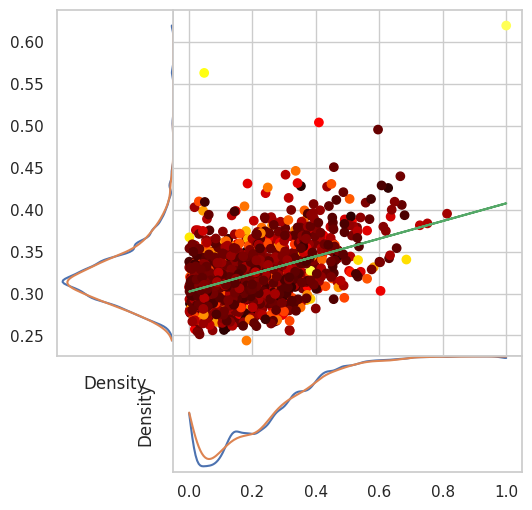

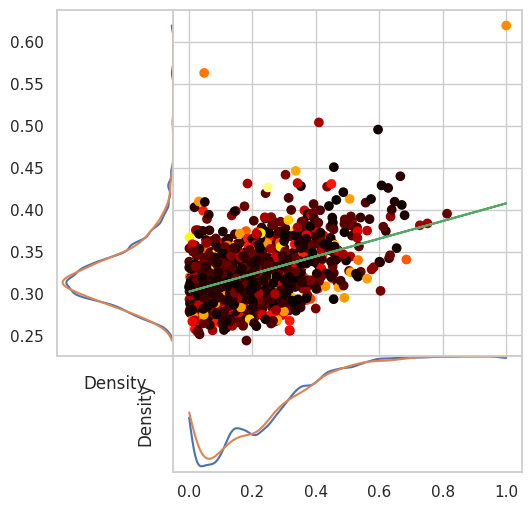

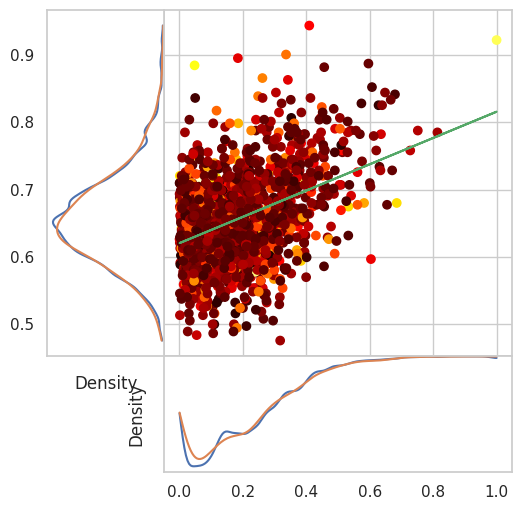

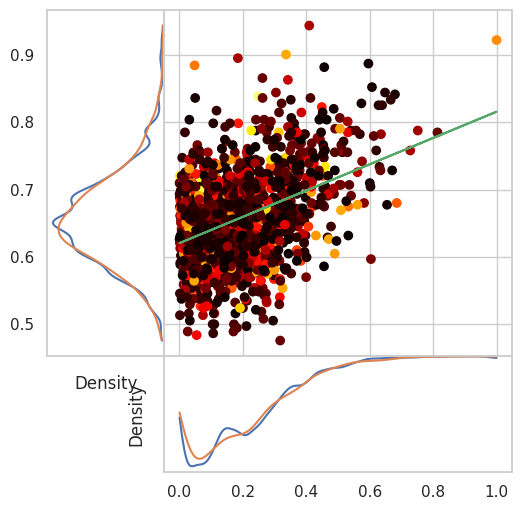

In [27]:
dynamic_vs_diseasediff(
    _diff_hic, cal_scores(ATAC_plot_list), 0.02,
    '/lmh_data/work/SEE/analyse/figure_file/Alzheimer/dynamic_vs_diseasediff(DLC1).pdf'
)
dynamic_vs_diseasediff(
    _diff_hic, cal_scores(H3K27ac_plot_list), 0.02,
)

dynamic_vs_diseasediff(
    _diff_frequency_hic, cal_scores(ATAC_plot_list), 0.8,
    '/lmh_data/work/SEE/analyse/figure_file/Alzheimer/dynamicfrequency_vs_diseasediff(DLC1).pdf'
)
dynamic_vs_diseasediff(
    _diff_frequency_hic, cal_scores(H3K27ac_plot_list), 0.8,
)

In [28]:
np.save('./tmp/{}_{}_diffhic.npy'.format(cell_type, gene_name), {
    'diff_hic': _diff_hic,
    'diff_frequency_hic': _diff_frequency_hic,
})